In [22]:
#!pip install datasets

In [23]:
import numpy as np 
from datasets import load_dataset
import torch
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim
from torch.nn.utils.rnn import pack_padded_sequence
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import spacy
from random import seed
from random import random
import torchtext
import pickle
import os
import matplotlib.pyplot as plt

In [24]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [25]:
data_path = "preprocessed"
word2index_path = "word2index.pkl"

In [26]:
class DiffusionDataset(Dataset):
    def __init__(self, data_path, word2index_path, train_split_ratio=0.8, train=True):
        self.data_path = data_path
        with open(word2index_path, 'rb') as f:
            self.word2index = pickle.load(f)
        self.vocab_size = len(self.word2index)
        self.eos_index = self.word2index["<EOS>"]
        self.train = train
        self.train_split_ratio = train_split_ratio
        self.files = os.listdir(data_path)

        n_image_prompt = int(len(self.files) / 2) # len(self.files) must be an even number

        # Calculate the split index
        self.split_index = int((self.train_split_ratio * n_image_prompt))
        
        # Calculate the total number of rows
        self.total_rows = 0

        if not train:
            self.total_rows = n_image_prompt - self.split_index
        else:
            self.total_rows = self.split_index

    def __len__(self):
        return self.total_rows

    def __getitem__(self, idx):
        # TODO: Recalculate the preprocessed data and then remove the +1 everywhere in this function
        if isinstance(idx, int):
            image = np.load(f"{data_path}\\image_{idx + 1}.npy")
            prompt = np.load(f"{data_path}\\prompt_{idx + 1}.npy")
            return torch.tensor(image), torch.tensor(prompt)
        else:
            image_batch = []
            prompt_batch = []
            for i in idx:
                image = np.load(f"{data_path}\\image_{i + 1}.npy")
                prompt = np.load(f"{data_path}\\prompt_{i + 1}.npy")
                image_batch.append(image)
                prompt_batch.append(prompt)
                return torch.tensor(image_batch), torch.tensor(prompt_batch)

In [27]:
class EncoderCNN(nn.Module):
    def __init__(self, embed_size, n_layers, hid_dim):
        super().__init__()

        self.resnet = models.resnet50(pretrained=True)
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, hid_dim)

        self.hidden_size = hid_dim
        self.n_layers = n_layers

    def forward(self, images):
        """Extract feature vectors from input images."""
        with torch.no_grad():
            features = self.resnet(images)

        batch_size = features.size(0)
        hidden = features.unsqueeze(0).expand(self.n_layers, batch_size, self.hidden_size)
        # Initialize the cell state with zeros
        cell = torch.zeros(self.n_layers, batch_size, self.hidden_size).to(features.device)
        return hidden, cell



class DecoderRNN(nn.Module):
    def __init__(self, output_dim, emb_dim, n_layers, hid_dim, dropout):
        super().__init__()
        
        self.output_dim = output_dim
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        
        self.embedding = nn.Embedding(output_dim, emb_dim)
        
        self.rnn = nn.LSTM(emb_dim, hid_dim, n_layers, dropout = dropout)
        
        self.fc_out = nn.Linear(hid_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input, hidden, cell):
        input = input.unsqueeze(0)
        
        embedded = self.dropout(self.embedding(input))
        
        output, (hidden, cell) = self.rnn(embedded, (hidden.contiguous(), cell.contiguous()))
        
        prediction = self.fc_out(output.squeeze(0))
        
        return prediction, hidden, cell

In [28]:
from torch.jit import script_if_tracing
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
       
    def forward(self, src, trg, teacher_forcing_ratio = float(0.5)):

        batch_size = trg.shape[0]
        trg_len = trg.shape[1]
        trg_vocab_size = self.decoder.output_dim
        
        #tensor to store decoder outputs
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
        
        #last hidden state of the encoder is used as the initial hidden state of the decoder
        hidden, cell = self.encoder(src)
        
        #first input to the decoder is the <sos> tokens
        input = trg[:, 0]

        for t in range(1, trg_len):
            #insert input token embedding, previous hidden and previous cell states
            #receive output tensor (predictions) and new hidden and cell states
            output, hidden, cell = self.decoder(input, hidden, cell)

            #place predictions in a tensor holding predictions for each token
            outputs[t] = output
            
            #get the highest predicted token from our predictions
            top1 = output.argmax(1) 

            #if teacher forcing, use actual next token as next input
            #if not, use predicted token)
            if self.train:
                input = trg[:,t] if random() < teacher_forcing_ratio else top1
            else:
                input = top1
        return outputs

In [29]:
dataset = DiffusionDataset(data_path, word2index_path, train_split_ratio=0.8, train=True)

In [30]:
embed_size = 512
hidden_size = 256
output_size = dataset.vocab_size
#n_layers = 5
n_layers = 2
dec_dropout = 0.5

batch_size = 64
num_epochs = 10
clip = 1

# seed random number generator
seed(1)

In [31]:
dataset.vocab_size

10003

In [32]:
encoder = EncoderCNN(embed_size, n_layers, hidden_size).to(device)
decoder = DecoderRNN(output_size, embed_size, n_layers, hidden_size, dec_dropout).to(device)
model = Seq2Seq(encoder, decoder, device).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

In [33]:
def collate_fn(data):
    # Sort a data list by caption length (descending order).
    data.sort(key=lambda x: len(x[1]), reverse=True)
    images, prompts = zip(*data)

    # Merge images (from tuple of 3D tensor to 4D tensor).
    images = torch.stack(images, 0)

    # Merge prompts (from tuple of 1D tensor to 2D tensor).
    lengths = [len(prompt) for prompt in prompts]
    #torch.full((len(prompts), max(lengths)), dataset.word2index["<PAD>"])
    padded_prompts = torch.zeros(len(prompts), max(lengths)).long()
    for i, cap in enumerate(prompts):
        end = lengths[i]
        padded_prompts[i, :end] = cap[:end]

    return images, padded_prompts, lengths

In [34]:
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)

In [35]:
x = [ x[1] for x in next(iter(data_loader)) ]
x[1]

tensor([   1, 1672,  528,    4,   45,  656, 3030,    3, 1821,    0,    6,  174,
         220,    4,   20,   26,    0,   76, 1246,    0, 1516, 1291, 2190,  376,
        1337,    5,  522,    4, 1485,    4, 1002,  325, 1259, 2587,  376, 2264,
        1516, 1337,    0,  292,  589,    0,   53, 1168,    0,   46,   22,    0,
          59,   54,    0,  152,  106,    0,  420,    0,   42,   24,    0,   38,
           0,   30,   24,    0,    7,  759,    0,  138,    7,    2,    0,    0,
           0])

In [36]:
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param.data, -0.08, 0.08)
        
model.apply(init_weights)

Seq2Seq(
  (encoder): EncoderCNN(
    (resnet): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplac

In [37]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 33,039,699 trainable parameters


In [38]:
#TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]
#TODO
#criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

In [39]:
def translate_output(output, word2index):
    index2word = {index: word for word, index in word2index.items()}  # Create index-to-word dictionary
    translated_sentences = []
    for seq in output:
        sentence = []
        for idx in seq:
            word = index2word.get(idx.item(), "<UNK>")
            if word == "<EOS>":
                break
            sentence.append(word)
        translated_sentence = " ".join(sentence)
        translated_sentences.append(translated_sentence)
    return translated_sentences

In [40]:
for i, (images, prompts, trg_lengths) in enumerate(data_loader):
    example_images = images
    example_prompts = prompts
    break

# Translate the example prompt
translated_example_prompts = translate_output(prompts, dataset.word2index)


In [41]:
def get_translations(images, prompts): 
    model.eval()
    with torch.no_grad():
        # Move images and prompts to the device
        images = images.to(device)
        prompts = prompts.to(device)

        # Perform forward pass for the images and prompts
        outputs = model(images, prompts)

        # Get the predicted words with the highest probability
        top1 = outputs.argmax(2).transpose(0, 1)

        # Translate the predicted output to words
        translated_output = translate_output(top1, dataset.word2index)

        return translated_output
    

In [42]:
# Training loop
translations_list = []  # List to store translated sentences

losses = []

for epoch in range(num_epochs):
    model.train()
    for i, (images, prompts, trg_lengths) in enumerate(data_loader):
        images = images.to(device)
        prompts = prompts.to(device)

        # TODO add packing?
        #targets = pack_padded_sequence(prompts, trg_lengths, batch_first=True)[0]

        optimizer.zero_grad()
        output = model(images, prompts)

        # Remove the <sos> token and reshape the output and target tensors
        output_dim = output.shape[-1]
        output = output[1:].view(-1, output_dim).contiguous()

        trg = prompts.transpose(0, 1)[1:].contiguous().view(-1)

        loss = criterion(output, trg)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()

        losses.append(loss.item())
        if i % batch_size == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Perplexity: {:5.4f}'
                  .format(epoch + 1, num_epochs, i, len(data_loader), loss.item(), np.exp(loss.item())))

    # Get translations after each epoch and append to the list
    translations_list.append(get_translations(example_images, example_prompts))

Epoch [1/10], Step [0/1250], Loss: 9.2043, Perplexity: 9939.5027
Epoch [1/10], Step [64/1250], Loss: 2.3686, Perplexity: 10.6824
Epoch [1/10], Step [128/1250], Loss: 2.6177, Perplexity: 13.7041
Epoch [1/10], Step [192/1250], Loss: 2.1679, Perplexity: 8.7400
Epoch [1/10], Step [256/1250], Loss: 2.4949, Perplexity: 12.1210
Epoch [1/10], Step [320/1250], Loss: 2.4462, Perplexity: 11.5449
Epoch [1/10], Step [384/1250], Loss: 2.1749, Perplexity: 8.8014
Epoch [1/10], Step [448/1250], Loss: 1.8295, Perplexity: 6.2305
Epoch [1/10], Step [512/1250], Loss: 2.1879, Perplexity: 8.9162
Epoch [1/10], Step [576/1250], Loss: 2.2598, Perplexity: 9.5812
Epoch [1/10], Step [640/1250], Loss: 1.9046, Perplexity: 6.7164
Epoch [1/10], Step [704/1250], Loss: 2.3399, Perplexity: 10.3798
Epoch [1/10], Step [768/1250], Loss: 2.3377, Perplexity: 10.3572
Epoch [1/10], Step [832/1250], Loss: 1.9777, Perplexity: 7.2262
Epoch [1/10], Step [896/1250], Loss: 1.9581, Perplexity: 7.0855
Epoch [1/10], Step [960/1250], Los

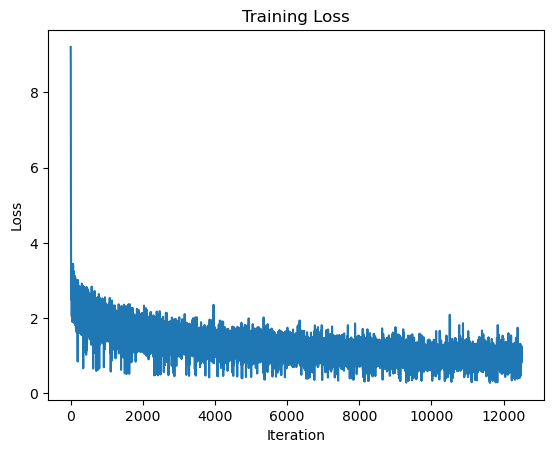

In [43]:
# Plot the losses
plt.plot(losses)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

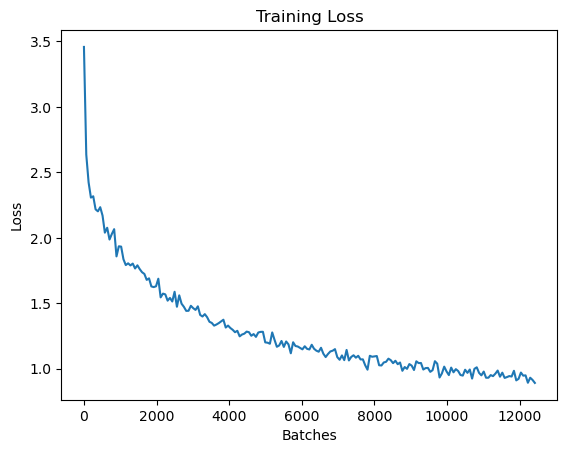

In [72]:
averaged_losses = []
for i in range(64, len(losses), 64):
    averaged_losses.append(np.array(losses[i-64:i]).mean())


# Plot the losses
plt.plot(np.arange(0, len(losses)-64, 64), averaged_losses)
plt.xlabel('Batches')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

In [53]:
len(losses)

12500

In [44]:
torch.save(model.state_dict(), 'parameters/seq2seq_v2.pth')

In [45]:
encoder = EncoderCNN(embed_size, n_layers, hidden_size).to(device)
decoder = DecoderRNN(output_size, embed_size, n_layers, hidden_size, dec_dropout).to(device)
model = Seq2Seq(encoder, decoder, device).to(device)
model.load_state_dict(torch.load("parameters/seq2seq_v2.pth"))
model.eval()

Seq2Seq(
  (encoder): EncoderCNN(
    (resnet): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplac

In [46]:
test_dataset = DiffusionDataset(data_path, word2index_path, train_split_ratio=0.8, train=False)
test_loader = DataLoader(test_dataset, batch_size, collate_fn=collate_fn)

In [47]:
def translate_plain(output, word2index):
    index2word = {index: word for word, index in word2index.items()}  # Create index-to-word dictionary
    translated_sentences = []
    for seq in output:
        sentence = []
        for idx in seq:
            word = index2word.get(idx.item(), "<UNK>")
            sentence.append(word)
        translated_sentences.append(sentence)
    return translated_sentences

In [48]:
import spacy

# Load the spaCy model
nlp = spacy.load('en_core_web_sm')

# Function to embed a word using spaCy
def embed_word(word):
    return nlp(str(word)).vector

# Function to embed a batch of sentences with variable sizes
def embed_batch(batch):
    embedded_batch = []
    for sentence in batch:
        embedded_sentence = []
        for word in sentence:
            embedded_word = embed_word(word)
            embedded_sentence.append(embedded_word)
        embedded_batch.append(embedded_sentence)
    return embedded_batch

In [49]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

def calculate_similarity(embedded_tensor, target):
    # Reshape the embedded tensor to 2D [n_samples, n_features]
    embedded_tensor_2d = np.reshape(embedded_tensor, (-1, embedded_tensor.shape[-1]))

    # Reshape the target to 2D [n_samples, n_features]
    target_2d = np.reshape(target, (-1, target.shape[-1]))

    # Calculate cosine similarity between the embedded tensor and the target
    similarity_matrix = cosine_similarity(embedded_tensor_2d, target_2d)

    # Reshape the similarity matrix back to the original tensor shape
    similarity_tensor = np.reshape(similarity_matrix, embedded_tensor.shape[:-1] + target.shape[:-1])

    return similarity_tensor

In [50]:
model.eval()  # Set the model to evaluation mode
total_cosine_similarity = 0
total_examples = 0

with torch.no_grad():
    for i, (images, prompts, trg_lengths) in enumerate(test_loader):
        images = images.to(device)
        prompts = prompts.to(device)

        prompt_translation = np.array(translate_plain(prompts, dataset.word2index))
        embedded_Prompts = np.array(embed_batch(prompt_translation))

        output = model(images, prompts)
        outputSentences = output.argmax(2).transpose(0, 1)
        output_translation = np.array(translate_plain(outputSentences, dataset.word2index))
        embedded_output = np.array(embed_batch(output_translation))


        cosine_similarities = calculate_similarity(embedded_output, embedded_Prompts)
        mean_cosine_similarity = cosine_similarities.mean()

        total_cosine_similarity += mean_cosine_similarity
        total_examples += 1

        if i % 1 == 0:
            print('Test Step [{}/{}], Mean Cosine Similarity: {:5.4f}'
                  .format(i, len(test_loader), mean_cosine_similarity))

average_cosine_similarity = total_cosine_similarity / total_examples
print('Average Mean Cosine Similarity: {:5.4f}'.format(average_cosine_similarity))

Test Step [0/313], Mean Cosine Similarity: 0.6271
Test Step [1/313], Mean Cosine Similarity: 0.4698
Test Step [2/313], Mean Cosine Similarity: 0.5763
Test Step [3/313], Mean Cosine Similarity: 0.5519
Test Step [4/313], Mean Cosine Similarity: 0.5908
Test Step [5/313], Mean Cosine Similarity: 0.6253
Test Step [6/313], Mean Cosine Similarity: 0.6941
Test Step [7/313], Mean Cosine Similarity: 0.5031
Test Step [8/313], Mean Cosine Similarity: 0.5689
Test Step [9/313], Mean Cosine Similarity: 0.6387
Test Step [10/313], Mean Cosine Similarity: 0.6454
Test Step [11/313], Mean Cosine Similarity: 0.6174
Test Step [12/313], Mean Cosine Similarity: 0.5190
Test Step [13/313], Mean Cosine Similarity: 0.5227
Test Step [14/313], Mean Cosine Similarity: 0.5733
Test Step [15/313], Mean Cosine Similarity: 0.6414
Test Step [16/313], Mean Cosine Similarity: 0.5375
Test Step [17/313], Mean Cosine Similarity: 0.6512
Test Step [18/313], Mean Cosine Similarity: 0.5249
Test Step [19/313], Mean Cosine Similarit